## Importing the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

# machine learning
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

## Loading the SuperStore data

In [2]:
# Laoding the data into a dataframe.
super_store_data = pd.read_excel("Data/Global_superstore_2016.xlsx")

In [3]:
super_store_data.shape

(51290, 24)

In [4]:
super_store_data.info() 
# info() gives us the number of non null values and the data type of each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   Postal Code     9994 non-null   float64       
 9   City            51290 non-null  object        
 10  State           51290 non-null  object        
 11  Country         51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Market          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

Dropping the Customer Name column, as it contains personally identifiable information.

In [5]:
super_store_data = super_store_data.drop("Customer Name",axis=1)
# Looking at the top 5 rows of the dataframe.
super_store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,73120.0,Oklahoma City,Oklahoma,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,NaN,Wollongong,New South Wales,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,NaN,Brisbane,Queensland,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Home Office,NaN,Berlin,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Consumer,NaN,Dakar,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Machine Learning Modelling
### Time Split

Performing time split, to split the data into train and test wherein test data, indicates if the customer purchased in the following 90 days and if yes, what's the sale amount

In [6]:
n_days = 90   
max_date = super_store_data['Order Date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd')

In [7]:
temporal_in_df = super_store_data[super_store_data['Order Date']<= cutoff][['Order Date', 
       'Customer ID', 'Sales']]
temporal_out_df = super_store_data[super_store_data['Order Date']> cutoff][['Order Date', 
       'Customer ID', 'Sales']]

## Feature Engineering

In [8]:
#make targets from out data
targets_df = temporal_out_df.groupby('Customer ID').sum().rename({'Sales':'spend_90_total'}, axis = 1).assign(spend_90_flag = 1)
targets_df

,spend_90_total,spend_90_flag
Customer ID,,
AA-1031545,368.2710,1
AA-1031558,45.9900,1
AA-103751406,149.8720,1
AA-103757,444.4200,1
AA-1037582,79.9000,1
...,...,...
ZC-219107,2254.2840,1
ZC-2191082,102.7400,1
ZD-1192538,140.5800,1


In [9]:
targets_df["spend_90_total"].sort_values()

Customer ID
PC-187451404        1.188
CC-123701402        1.248
DK-133751402        1.392
ND-846095           1.935
AH-12068            2.052
                  ...    
DL-133158        7383.810
GT-146351408     8167.420
BF-1100558       9286.830
HL-150401406    10522.550
TA-213851406    13716.458
Name: spend_90_total, Length: 2784, dtype: float64

In [10]:
# make recency (date) features from in data
max_date = temporal_in_df['Order Date'].max()

In [11]:
recency_features_df = temporal_in_df[['Customer ID', 'Order Date']].groupby('Customer ID').apply(lambda x: (x['Order Date'].max() - max_date)/ pd.to_timedelta(1, 'day')).to_frame().set_axis(['recency'], axis = 1)

In [12]:
recency_features_df.head()

,recency
Customer ID,
AA-10315102,-268.0
AA-10315120,-869.0
AA-10315139,-59.0
AA-103151402,-94.0
AA-103151404,-728.0


In [13]:
# make frequency (count features from in data)
frequency_features_df = temporal_in_df[['Customer ID', 'Order Date']].groupby('Customer ID').count().set_axis(['frequency'], axis = 1)
frequency_features_df.head()

,frequency
Customer ID,
AA-10315102,6
AA-10315120,1
AA-10315139,13
AA-103151402,6
AA-103151404,3


In [14]:
# make price (monitery features from in data)
price_features_df = temporal_in_df.groupby('Customer ID').aggregate({'Sales':['sum', 'mean']}).set_axis(['price_sum', 'price_mean'], axis = 1)
price_features_df.head()

,price_sum,price_mean
Customer ID,,
AA-10315102,544.656,90.776000
AA-10315120,2713.410,2713.410000
AA-10315139,2955.798,227.369077
AA-103151402,4780.552,796.758667
AA-103151404,753.508,251.169333


In [15]:
# combine features
features_df = pd.concat([recency_features_df, frequency_features_df, price_features_df], axis = 1).merge(targets_df, left_index = True, right_index = True, how = 'left').fillna(0)
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
Customer ID,,,,,,
AA-10315102,-268.0,6,544.6560,90.776000,0.0,0.0
AA-10315120,-869.0,1,2713.4100,2713.410000,0.0,0.0
AA-10315139,-59.0,13,2955.7980,227.369077,0.0,0.0
AA-103151402,-94.0,6,4780.5520,796.758667,0.0,0.0
AA-103151404,-728.0,3,753.5080,251.169333,0.0,0.0
...,...,...,...,...,...,...
ZD-2192548,-660.0,4,1302.1680,325.542000,0.0,0.0
ZD-2192564,-1319.0,4,1225.3920,306.348000,0.0,0.0
ZD-219257,-1108.0,1,59.9400,59.940000,0.0,0.0


## Perfroming various predictive modelling techniques:

### Predictve modelling for next 90 days behaviour:

#### How much will the customers spend in the next 90 days?

In [16]:
# machine laerning

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [17]:
features_df.loc['AA-10315139',:]

recency            -59.000000
frequency           13.000000
price_sum         2955.798000
price_mean         227.369077
spend_90_total       0.000000
spend_90_flag        0.000000
Name: AA-10315139, dtype: float64

In [18]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

In [19]:
# next 90 days spend prediction
y_spend = features_df['spend_90_total']

In [20]:
X.shape

(16002, 4)

In [21]:
y_spend.shape

(16002,)

##### XGBoost

In [22]:
xgb_reg_spec = XGBRegressor(objective='reg:squarederror', random_state=123)

In [23]:
# Creating a GridSearchCV to tune the hyperparameters
xgb_reg_model =GridSearchCV(estimator=xgb_reg_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [24]:
# Fitting the Model
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=123, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
        

In [25]:
xgb_reg_model.best_score_ # NAME of the best parameters model.

-70.10027364523182

In [26]:
xgb_reg_model.best_params_ # best Hyperparameter value

{'learning_rate': 0.01}

In [27]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
# Merging the predictions to the data.
predictions_xgb_reg_model = xgb_reg_model.predict(X)


In [29]:
predictions_xgb_reg_model

array([38.020813, 33.49133 , 42.762573, ...,  9.285524, 22.59381 ,
       22.341291], dtype=float32)

In [30]:
pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_xgb,Customer ID,recency,frequency,price_sum,price_mean
0,38.020813,AA-10315102,-268.0,6,544.6560,90.776000
1,33.491329,AA-10315120,-869.0,1,2713.4100,2713.410000
2,42.762573,AA-10315139,-59.0,13,2955.7980,227.369077
3,37.836720,AA-103151402,-94.0,6,4780.5520,796.758667
4,31.978191,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,32.042683,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,11.804090,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,9.285524,ZD-219257,-1108.0,1,59.9400,59.940000
16000,22.593809,ZD-2192582,-106.0,2,678.1014,339.050700


In [31]:
pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True).to_csv("XGB_reg_prediction.csv")

##### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [33]:

lr = LinearRegression()


In [34]:
parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]}
lr_reg_model = GridSearchCV(lr,parameters, cv=5, scoring='neg_mean_absolute_error')
lr_reg_model.fit(X, y_spend)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [35]:
lr_reg_model.best_score_

-79.33522829273292

In [36]:
lr_reg_model.best_params_

{'copy_X': True, 'fit_intercept': False}

In [37]:
predictions_lr_reg_model = lr_reg_model.predict(X)

In [38]:
pd.DataFrame({"prediction_lr" : predictions_lr_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_lr,Customer ID,recency,frequency,price_sum,price_mean
0,63.835429,AA-10315102,-268.0,6,544.6560,90.776000
1,92.272541,AA-10315120,-869.0,1,2713.4100,2713.410000
2,117.169248,AA-10315139,-59.0,13,2955.7980,227.369077
3,52.441168,AA-103151402,-94.0,6,4780.5520,796.758667
4,45.418695,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,52.631985,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,64.151615,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,30.971375,ZD-219257,-1108.0,1,59.9400,59.940000
16000,27.822957,ZD-2192582,-106.0,2,678.1014,339.050700


In [39]:
pd.DataFrame({"prediction_lr" : predictions_lr_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True).to_csv("lr_reg_prediction.csv")

##### Random Forest Regressor

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
param_grid = dict(n_estimators = [10, 20, 50, 100, 500, 1000], max_depth = [2, 5], max_features = ['auto', 'sqrt', 'log2'])

In [42]:
rf = RandomForestRegressor()
rf_regressor =GridSearchCV(estimator=rf, param_grid = param_grid, scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [43]:
rf_regressor.fit(X, y_spend)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [44]:
rf_regressor.best_score_

-83.76601308685126

In [45]:
predictions_rf_reg_model = rf_regressor.predict(X)

In [46]:
pd.DataFrame({"prediction_rf" : predictions_rf_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_rf,Customer ID,recency,frequency,price_sum,price_mean
0,61.006709,AA-10315102,-268.0,6,544.6560,90.776000
1,57.549318,AA-10315120,-869.0,1,2713.4100,2713.410000
2,79.859482,AA-10315139,-59.0,13,2955.7980,227.369077
3,62.933810,AA-103151402,-94.0,6,4780.5520,796.758667
4,52.643518,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,50.982748,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,35.693631,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,20.432058,ZD-219257,-1108.0,1,59.9400,59.940000
16000,37.853365,ZD-2192582,-106.0,2,678.1014,339.050700


In [47]:
pd.DataFrame({"prediction_rf" : predictions_rf_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True).to_csv("rf_reg_prediction.csv")

#### Will a customer make a purchase in next 90 days

In [48]:
# Next 90 days spend probability
y_prob = features_df['spend_90_flag']

In [49]:
xgb_clf_spec = XGBClassifier(objective='binary:logistic', random_state= 123)

##### XGBoost

In [50]:
xgb_clf_model =GridSearchCV(estimator=xgb_clf_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='roc_auc', refit= True, cv = 5) 

In [51]:
xgb_clf_model.fit(X, y_prob)

[12:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=

In [52]:
xgb_clf_model.best_score_

0.572016125072192

In [53]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [54]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
predictions_xgb_clf_model = xgb_clf_model.predict(X)

In [56]:
pd.DataFrame(xgb_clf_model.predict(X)).value_counts()

0.0    15998
1.0        4
dtype: int64

In [57]:
#pd.DataFrame({"prediction_xgb_clf" : predictions_xgb_clf_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)
pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1'])

,prediction_xgb_clf_0,prediction_xgb_clf_1
0,0.747942,0.252058
1,0.777251,0.222749
2,0.750724,0.249276
3,0.748390,0.251610
4,0.763143,0.236857
...,...,...
15997,0.761432,0.238568
15998,0.770570,0.229430
15999,0.783490,0.216510
16000,0.763946,0.236054


In [58]:
pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_xgb_clf_0,prediction_xgb_clf_1,Customer ID,recency,frequency,price_sum,price_mean
0,0.747942,0.252058,AA-10315102,-268.0,6,544.6560,90.776000
1,0.777251,0.222749,AA-10315120,-869.0,1,2713.4100,2713.410000
2,0.750724,0.249276,AA-10315139,-59.0,13,2955.7980,227.369077
3,0.748390,0.251610,AA-103151402,-94.0,6,4780.5520,796.758667
4,0.763143,0.236857,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...,...
15997,0.761432,0.238568,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,0.770570,0.229430,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,0.783490,0.216510,ZD-219257,-1108.0,1,59.9400,59.940000
16000,0.763946,0.236054,ZD-2192582,-106.0,2,678.1014,339.050700


In [59]:
pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index(),left_index=True, right_index=True).to_csv("xgb_clf_prediction.csv")

##### Logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
parameters = {'penalty': ["l1", "l2"], 'solver': ["liblinear","saga"]}

logr = LogisticRegression()
logr_clf_model = GridSearchCV(logr,parameters, cv=5, scoring='roc_auc')
logr_clf_model.fit(X, y_prob)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [62]:
logr_clf_model.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

In [63]:
logr_clf_model.best_score_

0.5812937963512682

In [64]:

pd.DataFrame(logr_clf_model.predict_proba(X),columns=['prediction_log_clf_0','prediction_log_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_log_clf_0,prediction_log_clf_1,Customer ID,recency,frequency,price_sum,price_mean
0,0.885545,0.114455,AA-10315102,-268.0,6,544.6560,90.776000
1,0.930931,0.069069,AA-10315120,-869.0,1,2713.4100,2713.410000
2,0.785903,0.214097,AA-10315139,-59.0,13,2955.7980,227.369077
3,0.875815,0.124185,AA-103151402,-94.0,6,4780.5520,796.758667
4,0.918944,0.081056,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...,...
15997,0.909745,0.090255,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,0.920710,0.079290,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,0.937678,0.062322,ZD-219257,-1108.0,1,59.9400,59.940000
16000,0.916176,0.083824,ZD-2192582,-106.0,2,678.1014,339.050700


In [65]:

pd.DataFrame(logr_clf_model.predict_proba(X),columns=['prediction_log_clf_0','prediction_log_clf_1']).merge(X.reset_index(),left_index=True, right_index=True).to_csv("log_clf_prediction.csv")

##### Random Forest Classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
parameters = { 'max_depth' : [2, 5], 'n_estimators' : [10, 20, 50, 100, 500, 1000],'max_features' : ['auto', 'sqrt', 'log2']}

rfc = RandomForestClassifier()
rfc_clf_model = GridSearchCV(rfc,parameters, cv=5, scoring='roc_auc')
rfc_clf_model.fit(X, y_prob)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='roc_auc')

In [68]:
rfc_clf_model.best_params_

{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 1000}

In [69]:
rfc_clf_model.best_score_

0.5807649782944608

In [70]:

pd.DataFrame(rfc_clf_model.predict_proba(X),columns=['prediction_rf_clf_0','prediction_rf_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_rf_clf_0,prediction_rf_clf_1,Customer ID,recency,frequency,price_sum,price_mean
0,0.894220,0.105780,AA-10315102,-268.0,6,544.6560,90.776000
1,0.919165,0.080835,AA-10315120,-869.0,1,2713.4100,2713.410000
2,0.871365,0.128635,AA-10315139,-59.0,13,2955.7980,227.369077
3,0.887578,0.112422,AA-103151402,-94.0,6,4780.5520,796.758667
4,0.911923,0.088077,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...,...
15997,0.900445,0.099555,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,0.905648,0.094352,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,0.938171,0.061829,ZD-219257,-1108.0,1,59.9400,59.940000
16000,0.912604,0.087396,ZD-2192582,-106.0,2,678.1014,339.050700


In [71]:

pd.DataFrame(rfc_clf_model.predict_proba(X),columns=['prediction_rf_clf_0','prediction_rf_clf_1']).merge(X.reset_index(),left_index=True, right_index=True).to_csv("rf_clf_prediction.csv")

In [72]:
!pip install plydata

In [73]:
import joblib

import plydata.cat_tools as cat

As XGBoostRegressor performed relatively better, considering it for further analysis:

#### Feature Importance

In [74]:
# Feature importance (global)
#importance | spend amount model

imp_spend_amount_dict = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

In [75]:
imp_spend_amount_df = pd.DataFrame(data = {'feature': list(imp_spend_amount_dict.keys()), 
                                   'value': list(imp_spend_amount_dict.values())}).assign(feature = lambda x : cat.cat_reorder(x['feature'], x['value']))

In [76]:
imp_spend_amount_df

,feature,value
0,recency,8.387816e+05
1,frequency,1.925278e+06
2,price_sum,4.369830e+06
3,price_mean,9.476169e+05


In [77]:
# Importance | Spend probability model
imp_spend_prob_dict = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

In [78]:
imp_spend_prob_df = pd.DataFrame(data = {'feature': list(imp_spend_prob_dict.keys()), 
                                   'value': list(imp_spend_prob_dict.values())}).assign(feature = lambda x : cat.cat_reorder(x['feature'], x['value']))

In [79]:
imp_spend_prob_df

,feature,value
0,recency,1.518297
1,frequency,5.831520
2,price_sum,1.389463
3,price_mean,1.922718


In [80]:
# save predictions
#predictions_df = pd.concat([pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis = 1), pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis = 1), features_df.reset_index()], axis =1)

In [81]:
predictions_df = pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)
predictions_df.columns = ['spend_90_total', 'Customer ID', 'recency', 'frequency', 'price_sum','price_mean']
predictions_df

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean
0,38.020813,AA-10315102,-268.0,6,544.6560,90.776000
1,33.491329,AA-10315120,-869.0,1,2713.4100,2713.410000
2,42.762573,AA-10315139,-59.0,13,2955.7980,227.369077
3,37.836720,AA-103151402,-94.0,6,4780.5520,796.758667
4,31.978191,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,32.042683,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,11.804090,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,9.285524,ZD-219257,-1108.0,1,59.9400,59.940000
16000,22.593809,ZD-2192582,-106.0,2,678.1014,339.050700


In [82]:
predictions_df = predictions_df.merge((pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index()["Customer ID"],left_index=True, right_index=True)), on="Customer ID")
predictions_df

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1
0,38.020813,AA-10315102,-268.0,6,544.6560,90.776000,0.747942,0.252058
1,33.491329,AA-10315120,-869.0,1,2713.4100,2713.410000,0.777251,0.222749
2,42.762573,AA-10315139,-59.0,13,2955.7980,227.369077,0.750724,0.249276
3,37.836720,AA-103151402,-94.0,6,4780.5520,796.758667,0.748390,0.251610
4,31.978191,AA-103151404,-728.0,3,753.5080,251.169333,0.763143,0.236857
...,...,...,...,...,...,...,...,...
15997,32.042683,ZD-2192548,-660.0,4,1302.1680,325.542000,0.761432,0.238568
15998,11.804090,ZD-2192564,-1319.0,4,1225.3920,306.348000,0.770570,0.229430
15999,9.285524,ZD-219257,-1108.0,1,59.9400,59.940000,0.783490,0.216510
16000,22.593809,ZD-2192582,-106.0,2,678.1014,339.050700,0.763946,0.236054


In [83]:
predictions_df[predictions_df["spend_90_total"]>0]["Customer ID"].count()

16002

In [84]:
## Which customers have the highest spend probability in the next 90 days
  ##Target for new products similar to what they have purchased in the past
predictions_df.sort_values('prediction_xgb_clf_1', ascending = False)

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1
1847,55.309856,BM-116501402,-141.0,14,3059.0830,218.505929,0.488360,0.511640
9069,55.309856,LC-168851404,-353.0,13,2864.0820,220.314000,0.488360,0.511640
7646,55.309856,JK-1609027,-272.0,14,3061.0200,218.644286,0.488360,0.511640
11220,37.836720,NC-185351404,-183.0,6,6275.4760,1045.912667,0.497004,0.502996
8739,35.619984,KL-166451404,-276.0,6,8450.3940,1408.399000,0.509092,0.490908
...,...,...,...,...,...,...,...,...
1714,16.037533,BF-975134,-1107.0,1,20.8800,20.880000,0.783490,0.216510
8443,13.142667,KC-1625597,-1038.0,1,10.2900,10.290000,0.783490,0.216510
8438,16.790062,KC-1625559,-1143.0,1,32.3883,32.388300,0.783490,0.216510
3762,15.770855,DA-1345039,-1105.0,1,16.7600,16.760000,0.783490,0.216510


##Which customers have recently purchased but are unlikely to buy
- Provide discounts, incentives to increase probability
- encourage referring a friend

In [85]:
predictions_df[predictions_df['recency']>-90][predictions_df['prediction_xgb_clf_1']<0.3].sort_values('prediction_xgb_clf_1', ascending = False)

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1
7385,31.013855,JG-516095,-44.0,6,97.3170,16.219500,0.700815,0.299185
15466,31.013855,TS-21430102,-5.0,6,223.9065,37.317750,0.702967,0.297033
15349,33.497589,TS-1116030,-15.0,4,92.9700,23.242500,0.703969,0.296031
3352,37.815552,CR-125807,-42.0,7,888.7950,126.970714,0.705040,0.294960
8780,37.815552,KM-1637591,-43.0,7,894.9540,127.850571,0.705040,0.294960
...,...,...,...,...,...,...,...,...
9830,22.239960,MC-1759031,-40.0,1,24.4800,24.480000,0.782569,0.217431
3638,16.450476,CS-250560,-30.0,1,12.3600,12.360000,0.782569,0.217431
3634,21.693832,CS-2490117,-79.0,1,14.4300,14.430000,0.782569,0.217431
13688,13.675350,SC-2072527,-9.0,1,44.2800,44.280000,0.782569,0.217431


In [86]:
## Missed opportunities- Big spenders that could be unlocked
  ## send bundle offers encouraging volume purchases
  ## focus on missed opportunities
predictions_df[predictions_df['spend_90_total'] == 0.0].sort_values('prediction_xgb_clf_1', ascending = False)

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1


## CLV prediction via probabilistic methods - Lifetimes package:

In [87]:
pip install lifetimes

Note: you may need to restart the kernel to use updated packages.


In [88]:
import lifetimes

In [97]:
super_store_data = super_store_data[super_store_data['Sales']>0]

In [98]:
# Creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(super_store_data, 'Customer ID', 'Order Date', 'Sales' )
summary = summary.reset_index()
summary.head()

,Customer ID,frequency,recency,T,monetary_value
0,AA-10315102,1.0,918.0,1276.0,139.9275
1,AA-10315120,0.0,0.0,959.0,0.0000
2,AA-10315139,3.0,319.0,468.0,923.3060
3,AA-103151402,1.0,483.0,667.0,374.4800
4,AA-103151404,1.0,553.0,1371.0,26.9600


<AxesSubplot:ylabel='Frequency'>

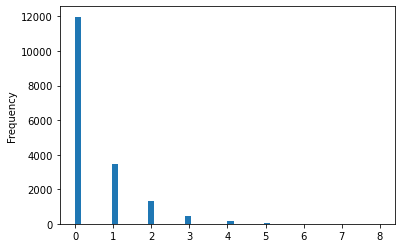

In [99]:
# Create a distribution of frequency to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)



In [100]:

one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

Percentage of customers purchase the item only once: 68.82 %


In [101]:
import datetime as dt
TRAIN = super_store_data[super_store_data["Order Date"] < super_store_data["Order Date"].max() - dt.timedelta(days = 30)]
TRAIN.shape

(49137, 23)

In [102]:
TEST =  super_store_data[super_store_data["Order Date"] >= super_store_data["Order Date"].max() - dt.timedelta(days = 30)]
TEST.shape

(2153, 23)

In [103]:
GD_data_LT = lifetimes.utils.summary_data_from_transaction_data(TRAIN, 'Customer ID', 'Order Date', 'Sales' )
GD_data_LT.head()

# frequency: total number of repeat purchases
# recency: the difference between the customer's last purchase and his first purchase
# T: the age of the client in the company
# monetary_value: average earnings per purchase

,frequency,recency,T,monetary_value
Customer ID,,,,
AA-10315102,1.0,918.0,1245.0,139.9275
AA-10315120,0.0,0.0,928.0,0.0000
AA-10315139,3.0,319.0,437.0,923.3060
AA-103151402,1.0,483.0,636.0,374.4800
AA-103151404,1.0,553.0,1340.0,26.9600


count    16891.000000
mean         0.457522
std          0.825521
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          8.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers that purchased the item only once: 69.55 %


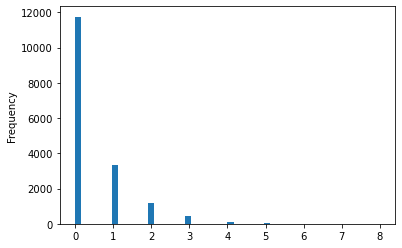

In [104]:
# Create a distribution of frequency to understand the customer frequency level
GD_data_LT['frequency'].plot(kind='hist', bins=50)
print(GD_data_LT['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(GD_data_LT['frequency'] == 0)/float(len(GD_data_LT))*(100),2)
print("Percentage of customers that purchased the item only once:", one_time_buyers ,"%")

In [130]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(GD_data_LT['frequency'], GD_data_LT['recency'], GD_data_LT['T'])
# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.388892,0.007437,0.374315,0.403469
alpha,470.401318,11.792686,447.287653,493.514983
a,0.006205,0.003296,-0.000255,0.012664
b,0.033203,0.016448,0.000966,0.065441


In [107]:
# Compute the customer alive probability
GD_data_LT['probability_alive'] = bgf.conditional_probability_alive(GD_data_LT['frequency'], GD_data_LT['recency'], GD_data_LT['T'])
GD_data_LT.head(10)

,frequency,recency,T,monetary_value,probability_alive
Customer ID,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,0.799568
AA-10315120,0.0,0.0,928.0,0.0000,1.000000
AA-10315139,3.0,319.0,437.0,923.3060,0.995131
AA-103151402,1.0,483.0,636.0,374.4800,0.813153
AA-103151404,1.0,553.0,1340.0,26.9600,0.707876
AA-103151406,0.0,0.0,1172.0,0.0000,1.000000
AA-1031548,0.0,0.0,480.0,0.0000,1.000000
AA-1031558,0.0,0.0,334.0,0.0000,1.000000
AA-103157,0.0,0.0,97.0,0.0000,1.000000


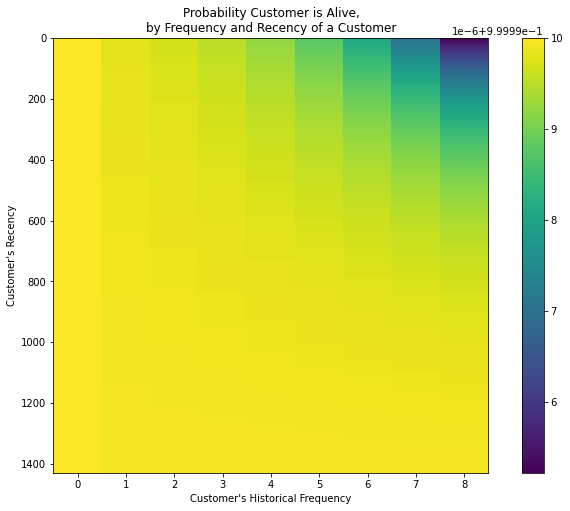

In [240]:
# Visual representation of relationship between recency and frequency
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)
plt.show()

In [109]:
#Predict future transaction for the next 30 days based on historical dataa
t = 30
GD_data_LT['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, GD_data_LT['frequency'], GD_data_LT['recency'], GD_data_LT['T']),2)
GD_data_LT.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,BD-113201404,6.0,591.0,593.0,184.984667,0.998754,0.18
1,BW-1111045,4.0,354.0,377.0,316.623375,0.997697,0.15
2,EP-139151402,4.0,396.0,414.0,628.335200,0.997766,0.15
3,MP-1796545,4.0,356.0,381.0,933.333000,0.997674,0.15
4,GT-147101402,3.0,194.0,199.0,39.471333,0.996880,0.15
5,SF-202001404,4.0,415.0,443.0,729.513500,0.997660,0.14
6,MR-175457,3.0,189.0,264.0,875.077000,0.995623,0.14
7,CS-121757,8.0,1012.0,1311.0,680.714250,0.995896,0.14
8,AR-1082545,6.0,861.0,909.0,555.065000,0.998457,0.14
9,MH-181151406,3.0,251.0,264.0,560.188000,0.996768,0.14


In [110]:
# Checking the relationship between frequency and monetary_value
GD_return_customers_summary = GD_data_LT[GD_data_LT['frequency']>0]
print(GD_return_customers_summary.shape)
GD_return_customers_summary.head()

(5143, 6)


,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
Customer ID,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,0.799568,0.02
AA-10315139,3.0,319.0,437.0,923.3060,0.995131,0.11
AA-103151402,1.0,483.0,636.0,374.4800,0.813153,0.03
AA-103151404,1.0,553.0,1340.0,26.9600,0.707876,0.02
AA-1031582,1.0,439.0,1102.0,61.3000,0.714393,0.02


In [111]:
# Checking the relationship between frequency and monetary_value
GD_return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.001725
monetary_value,0.001725,1.000000


In [112]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(GD_return_customers_summary['frequency'], GD_return_customers_summary['monetary_value'])
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.373907,0.066093,3.244365,3.503450
q,0.335324,0.005328,0.324881,0.345768
v,3.170847,0.068221,3.037135,3.304560


In [113]:
# Calculating the conditional expected average profit for each customer per transaction
GD_data_LT_vF = GD_data_LT[GD_data_LT['monetary_value'] >0]
GD_data_LT_vF['exp_avg_sales'] = ggf.conditional_expected_average_profit(GD_data_LT_vF['frequency'],
                                       GD_data_LT_vF['monetary_value'])
GD_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
Customer ID,,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,0.799568,0.02,178.205709
AA-10315139,3.0,319.0,437.0,923.3060,0.995131,0.11,989.330536
AA-103151402,1.0,483.0,636.0,374.4800,0.813153,0.03,470.302684
AA-103151404,1.0,553.0,1340.0,26.9600,0.707876,0.02,37.523068
AA-1031582,1.0,439.0,1102.0,61.3000,0.714393,0.02,80.287951


In [114]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {GD_data_LT_vF['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {GD_data_LT_vF['monetary_value'].mean()}")

Expected Average Sales: 613.0187971889736
Actual Average Sales: 511.3382036724357


In [115]:
# Predicting Customer Lifetime Value for the next 30 days
GD_data_LT_vF['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               GD_data_LT_vF['frequency'],
                                                               GD_data_LT_vF['recency'],
                                                               GD_data_LT_vF['T'],
                                                               GD_data_LT_vF['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate
GD_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
Customer ID,,,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,0.799568,0.02,178.205709,3.426305
AA-10315139,3.0,319.0,437.0,923.3060,0.995131,0.11,989.330536,109.198437
AA-103151402,1.0,483.0,636.0,374.4800,0.813153,0.03,470.302684,14.256816
AA-103151404,1.0,553.0,1340.0,26.9600,0.707876,0.02,37.523068,0.605199
AA-1031582,1.0,439.0,1102.0,61.3000,0.714393,0.02,80.287951,1.504646


In [116]:
GD_data_LT_vF['manual_predicted_clv'] = GD_data_LT_vF['pred_num_txn'] * GD_data_LT_vF['exp_avg_sales']
GD_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
Customer ID,,,,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,0.799568,0.02,178.205709,3.426305,3.564114
AA-10315139,3.0,319.0,437.0,923.3060,0.995131,0.11,989.330536,109.198437,108.826359
AA-103151402,1.0,483.0,636.0,374.4800,0.813153,0.03,470.302684,14.256816,14.109081
AA-103151404,1.0,553.0,1340.0,26.9600,0.707876,0.02,37.523068,0.605199,0.750461
AA-1031582,1.0,439.0,1102.0,61.3000,0.714393,0.02,80.287951,1.504646,1.605759


#### Test

In [117]:
TEST.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
19,49463,TZ-2015-RH9555129-42343,2015-12-05,2015-12-07,Second Class,RH-9555129,Consumer,NaN,Uvinza,Kigoma,...,OFF-AP-4967,Office Supplies,Appliances,"KitchenAid Stove, White",3409.740,6,0.0,818.280,763.380,High
49,6550,MX-2015-JH15820141-42356,2015-12-18,2015-12-20,Second Class,JH-15820141,Consumer,NaN,Paysandú,Paysandú,...,FUR-CH-4531,Furniture,Chairs,"Harbour Creations Executive Leather Armchair, ...",3473.140,11,0.0,868.120,634.529,High
61,34496,CA-2015-AH10030140-42357,2015-12-19,2015-12-23,Standard Class,AH-100301406,Corporate,19134.0,Philadelphia,Pennsylvania,...,OFF-AR-3276,Office Supplies,Art,Avery Fluorescent Highlighter Four-Color Set,18.704,7,0.2,2.338,1.130,Medium
66,16653,IT-2015-DK13090120-42345,2015-12-07,2015-12-08,First Class,DK-13090120,Consumer,NaN,Seville,Andalusía,...,FUR-BO-5760,Furniture,Bookcases,"Safco Classic Bookcase, Metal",2188.050,5,0.0,1050.150,593.910,High
67,28932,IN-2015-CS1184558-42354,2015-12-16,2015-12-19,First Class,CS-1184558,Corporate,NaN,Raipur,Uttarakhand,...,FUR-TA-3779,Furniture,Tables,"Chromcraft Wood Table, Rectangular",1920.360,4,0.0,652.920,592.770,Critical


In [118]:
ACTUAL = TEST.groupby("Customer ID")["Sales"].sum().reset_index()

In [119]:
ACTUAL.rename(columns ={"Sales":"actual_amount_spent_in_next_30_days"}, inplace = True)

In [120]:
Pred_vs_Actual = GD_data_LT_vF.merge(ACTUAL, on = "Customer ID", how = "left")
Pred_vs_Actual.fillna(0, inplace = True)

In [121]:
Pred_vs_Actual.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days
0,AA-10315102,1.0,918.0,1245.0,139.9275,0.799568,0.02,178.205709,3.426305,3.564114,0.0
1,AA-10315139,3.0,319.0,437.0,923.3060,0.995131,0.11,989.330536,109.198437,108.826359,0.0
2,AA-103151402,1.0,483.0,636.0,374.4800,0.813153,0.03,470.302684,14.256816,14.109081,0.0
3,AA-103151404,1.0,553.0,1340.0,26.9600,0.707876,0.02,37.523068,0.605199,0.750461,0.0
4,AA-1031582,1.0,439.0,1102.0,61.3000,0.714393,0.02,80.287951,1.504646,1.605759,0.0


In [122]:
Pred_vs_Actual["difference"] = Pred_vs_Actual["manual_predicted_clv"] - Pred_vs_Actual["actual_amount_spent_in_next_30_days"]

In [123]:
Pred_vs_Actual.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days,difference
0,AA-10315102,1.0,918.0,1245.0,139.9275,0.799568,0.02,178.205709,3.426305,3.564114,0.0,3.564114
1,AA-10315139,3.0,319.0,437.0,923.3060,0.995131,0.11,989.330536,109.198437,108.826359,0.0,108.826359
2,AA-103151402,1.0,483.0,636.0,374.4800,0.813153,0.03,470.302684,14.256816,14.109081,0.0,14.109081
3,AA-103151404,1.0,553.0,1340.0,26.9600,0.707876,0.02,37.523068,0.605199,0.750461,0.0,0.750461
4,AA-1031582,1.0,439.0,1102.0,61.3000,0.714393,0.02,80.287951,1.504646,1.605759,0.0,1.605759


<AxesSubplot:>

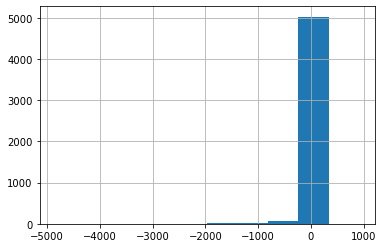

In [124]:
Pred_vs_Actual["difference"].hist()

In [125]:
Pred_vs_Actual["difference"].describe()

count    5143.000000
mean       -1.913735
std       209.413131
min     -4853.738348
25%         2.621446
50%         9.403200
75%        27.639735
max       915.596709
Name: difference, dtype: float64

In [126]:
Pred_vs_Actual.sort_values('actual_amount_spent_in_next_30_days', ascending = False)

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days,difference
4736,TA-213857,1.0,165.0,1101.0,421.6800,0.603422,0.02,529.082604,8.380450,10.581652,4864.3200,-4853.738348
908,CD-1192045,2.0,646.0,729.0,57.1455,0.992923,0.06,65.148172,3.826435,3.908890,4046.6790,-4042.770110
2777,KH-165101404,2.0,405.0,1152.0,377.1070,0.974449,0.04,420.070338,17.901043,16.802814,3955.5070,-3938.704186
345,AS-1004545,2.0,645.0,1252.0,171.3600,0.983326,0.04,191.842345,7.770798,7.673694,3788.3310,-3780.657306
3150,MC-1742559,1.0,82.0,529.0,101.7174,0.701382,0.03,130.621246,3.780992,3.918637,3696.0315,-3692.112863
...,...,...,...,...,...,...,...,...,...,...,...,...
1771,ES-14080139,1.0,205.0,950.0,14.9700,0.655850,0.02,22.591474,0.430271,0.451829,0.0000,0.451829
1770,ES-1402059,1.0,652.0,818.0,32.8332,0.815442,0.03,44.837183,1.170516,1.345115,0.0000,1.345115
1767,ES-1402028,1.0,61.0,233.0,86.9600,0.783788,0.05,112.243306,5.158165,5.612165,0.0000,5.612165
1766,ES-1402027,4.0,638.0,912.0,285.4875,0.994635,0.09,301.110245,28.240437,27.099922,0.0000,27.099922


In [127]:
# MAE of the Lifetimes based prediction
mean_absolute_error(Pred_vs_Actual["actual_amount_spent_in_next_30_days"],Pred_vs_Actual["manual_predicted_clv"])

46.5068970000619

In [128]:
Pred_vs_Actual.to_csv("lifetimes_based_global_datastore.csv")